In [26]:
import os
from pathlib import Path
import numpy as np
import random
import matplotlib.pyplot as plt

from IPython.display import Image, display

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.python.keras import losses
import keras.backend as K
from PIL import ImageOps

In [2]:
# import zipfile
# with zipfile.ZipFile("data/images.zip","r") as zip_ref:
#     zip_ref.extractall("data")
    
# with zipfile.ZipFile("data/masks.zip","r") as zip_ref:
#     zip_ref.extractall("data")

# Loading images

In [41]:
path = Path().resolve()
img_dir = os.path.join(path, 'data/images')
msk_dir = os.path.join(path, 'data/masks')

In [42]:
input_dir = img_dir
target_dir = msk_dir
img_size = (256, 256)
num_classes = 1
batch_size = 32

In [43]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1999
/home/jovyan/my_work/Quantum Black/data/images/silos_256-0-0--6-14--19-28655.png | /home/jovyan/my_work/Quantum Black/data/masks/silos_256-0-0--6-14--19-28655.png
/home/jovyan/my_work/Quantum Black/data/images/silos_256-0-0--6-14--25-30886.png | /home/jovyan/my_work/Quantum Black/data/masks/silos_256-0-0--6-14--25-30886.png
/home/jovyan/my_work/Quantum Black/data/images/silos_256-0-0--6-14--33-30848.png | /home/jovyan/my_work/Quantum Black/data/masks/silos_256-0-0--6-14--33-30848.png
/home/jovyan/my_work/Quantum Black/data/images/silos_256-0-0--6-14--65-28655.png | /home/jovyan/my_work/Quantum Black/data/masks/silos_256-0-0--6-14--65-28655.png
/home/jovyan/my_work/Quantum Black/data/images/silos_256-0-0--6-14--66-28655.png | /home/jovyan/my_work/Quantum Black/data/masks/silos_256-0-0--6-14--66-28655.png
/home/jovyan/my_work/Quantum Black/data/images/silos_256-0-0--6-14--8-28238.png | /home/jovyan/my_work/Quantum Black/data/masks/silos_256-0-0--6-14--8-28238.png


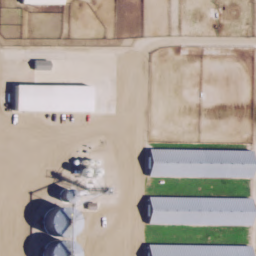

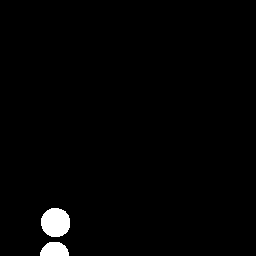

In [6]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #1
display(Image(filename=input_img_paths[1]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[1]))
display(img)

In [7]:
path = target_img_paths[1]

from PIL import Image
from numpy import asarray
 

img = Image.open(path)
 
# asarray() class is used to convert
# PIL images into NumPy arrays
numpydata = asarray(img)

# Class for loading & vectorizing batches of data

In [44]:
class GenerateSeq(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.array(img).reshape(256, 256, 1) / 255
            # y[j] = np.expand_dims(img, 2) / 255
        return x, y

In [45]:
# Split our img paths into a training and a validation set
val_rate = 0.2

val_samples = int(np.floor(val_rate*len(input_img_paths)))

random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = GenerateSeq(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = GenerateSeq(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# Model

In [139]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Train model

In [11]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Custom losses

In [17]:
def dice_loss(y_true, y_pred, smooth=1.):
    
    y_pred = tf.cast(y_pred, tf.float64)
    y_true = tf.cast(y_true, tf.float64)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    score = (2.*intersection + smooth) / sum_
    loss =  1 - score
    return tf.reduce_mean(score)

In [94]:
def jaccard_distance(y_true, y_pred, smooth=100.):
    
    y_pred = tf.cast(y_pred, tf.float64)
    y_true = tf.cast(y_true, tf.float64)
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [159]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

# model.compile(optimizer="rmsprop", loss="BinaryCrossentropy")

model.compile(optimizer="rmsprop", loss=jaccard_distance)

callbacks = [
    keras.callbacks.ModelCheckpoint("silo_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
50/50 [==============================] - 28s 482ms/step - loss: 25.5126 - val_loss: 43.5963
Epoch 2/10
50/50 [==============================] - 14s 274ms/step - loss: 23.0610 - val_loss: 31.9690
Epoch 3/10
50/50 [==============================] - 14s 269ms/step - loss: 22.1553 - val_loss: 33.1472
Epoch 4/10
50/50 [==============================] - 13s 267ms/step - loss: 21.2205 - val_loss: 32.3162
Epoch 5/10
50/50 [==============================] - 22s 450ms/step - loss: 20.6013 - val_loss: 34.7979
Epoch 6/10
50/50 [==============================] - 23s 465ms/step - loss: 19.4339 - val_loss: 32.5551
Epoch 7/10
50/50 [==============================] - 21s 407ms/step - loss: 19.2351 - val_loss: 31.8805
Epoch 8/10
50/50 [==============================] - 19s 386ms/step - loss: 19.3115 - val_loss: 31.2845
Epoch 9/10
50/50 [==============================] - 18s 353ms/step - loss: 18.3239 - val_loss: 28.7833
Epoch 10/10
50/50 [==============================] - 19s 386ms/step - los

In [171]:
model.save_weights('models/double_training.h5')

# Check predictions

In [160]:
# Generate predictions for all images in the validation set

val_preds = model.predict(val_gen)

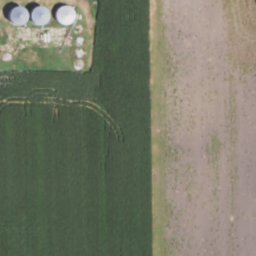

True mask


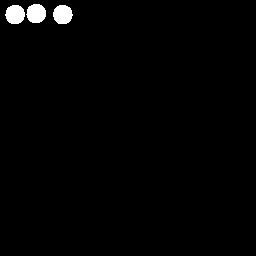

Predicted mask


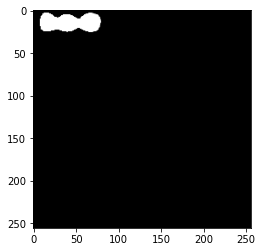

In [168]:
# def display_mask(i):
#     """Quick utility to display a model's prediction."""
#     mask = val_preds[i].reshape(256,256)
#     img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
#     display(img)


# Display results for validation image #10
i = 22

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
print('True mask')
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
print('Predicted mask')
mask = val_preds[i].reshape(256,256)
imgplot = plt.imshow(mask, cmap='gray')
plt.show()